In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import itertools
import time

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class GreenHouseEnv(object):
  def __init__(self,m,n,o):  #m, n and o is the dimension of the grid
    #self.grid = np.zeros((m,n))
    self.m = m
    self.n = n
    self.o = o
    self.statePosDict ={}
    self.statePositionDict(m,n,o)
    #self.obsSpace = [[[k for k in range(self.o)] for j in range(self.n)] for i in range(self.m)]
    self.obsSpace = [i for i in range(self.m * self.n * self.o)]
    #print(self.obsSpace)
    self.actSpace = {'U': 0, 'D': 1, 'L': 2, 'R': 3, 'B': 4, 'F': 5}
    self.possibleAct = ['U','D','L','R', 'B', 'F']
    self.addComponents()
    self.rules_arr_rew = [9999,9999,0,0,0,0]
    self.objectives_comp_1 = {
        1: 'heater',
        2: 'water tank'
    }
    self.rew_vec = [99999,99999,0,0,0,0] #6 is number of objectives
    self.log_avg_d = []
    self.log_best_d = []
    self.rew_obtained = []
    self.best_pos = [999,999,999]
    self.best_pos_log = []
    self.prev_distance = [99999,99999,0,0,0,0] #to keep record of the prev distance
  def addComponents(self):
    self.components = [1,2,3,4,5,6,7,8] #[1,2,3,4,5,6,7,8,9,10]

    if len(self.components)> self.m*self.n*self.o:
      print('errorrrr')
      return 0

    
    self.comp_dictionary = {
        1: 'heater',
        2: 'water tank',
        3: 'pack soil',
        4: 'heat sensor',
        5: 'camera',
        6: 'fan',
        7: 'led',
        8: 'water pump',
        9: 'PCB',
        10: 'Pipes'
    }

    #self.grid = np.zeros((self.m,self.n,self.o))
    #print('grid: 111', self.grid)  
    self.occupied = []
    len_com = len(self.components)
    i = 0
    while len_com != 0:
      #print('i',i)
      x = random.choice(range(0,self.m))
      y = random.choice(range(0,self.n))
      z = random.choice(range(0,self.o))
      if (x,y,z) not in self.occupied:
        #self.grid[x,y,z] = components[i]
        self.occupied.append((x,y,z))
        len_com -= 1
        i += 1
      

      #else:
      #  x = random.choice(range(0,self.m))
      #  y = random.choice(range(0,self.n))
      #  z = random.choice(range(0,self.o))
      #  self.grid[x,y,z] = components[i]
      #  self.occupied.append((x,y,z))
    #print('grid: ', np.shape(self.grid))   
    print('occupied:',self.occupied)

  def getComponentPosition(self, index):
    return self.occupied[index]

  def getComponentValue(self, pos):
    if pos in self.occupied:
      id = self.occupied.index(pos)
      val = self.components[id]
    else:
      val = -1
    return val

  def setState(self, state, comp_id):
    x,y,z = self.getComponentPosition(comp_id)
    #self.grid[x,y,z] = -1
    x,y,z = state
    #self.grid[x,y,z] = components[comp_id]
    self.occupied[comp_id] = state

  def totalDistance(self, components):
    total_dist = 0
    for i in range(len(components)):
      for j in range(len(components)):
        i_pos = self.getComponentPosition(i+1)
        j_pos = self.getComponentPosition(j+1)
        dist_temp = self.calcDistance(i_pos, j_pos)
        total_dist += dist_temp

    return total_dist


  def rewardComponents(self, component):
    #print(self.rules_arr_rew)
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)


    
    #rule 1 - minimize distance between pack soil, water tank and water pump
    if component == 2 or component == 3 or component == 8:
      #print('RULE 1')
      d1 = self.calcDistance(1,2)
      d2 = self.calcDistance(2,7)
      d3 = self.calcDistance(1,7)
      avg_d = (d1 + d2 + d3)/3
      #print('avg',avg_d)
      
      temp_rew_vec[0] = avg_d

      #find diff from last distance and new distance
      diff_1 = avg_d - self.rew_vec[0]
      diff_2 = self.prev_distance[0] - self.rew_vec[0]

      diff = diff_1 - diff_2

      
      #reward for moving closer or away from the best distance
      if avg_d>self.prev_distance[0]: # move away
        rew_comp[0] = -1
      elif avg_d<self.prev_distance[0]: # move closer
        #if it moves closer then check for the best score
        if avg_d<self.rew_vec[0]: #set a new best score
          rew_comp[0] = 10
          self.rew_vec[0] = avg_d
          pos1 = self.getComponentPosition(1)
          pos2 = self.getComponentPosition(2)
          pos3 = self.getComponentPosition(7)
          self.best_pos = [pos1, pos2, pos3]
          self.best_pos_log.append(self.best_pos)
        elif avg_d==self.rew_vec[0]: #find a similar best score
          rew_comp[0] = 5
          #add code here later to save the coordinates if it is different from the previous one
        else:
          rew_comp[0] = 2
      elif avg_d==self.prev_distance[0]: # stay in same place
        rew_comp[0] = 0.5

        

      #save the new distance as prev distance
      self.prev_distance[0] = avg_d
      
      '''
      if avg_d<self.rew_vec[0]:
        rew_comp[0] = 1
        self.rew_vec[0] = avg_d
        
      elif avg_d>self.rew_vec[0]:
        rew_comp[0] = -20
      else:
        rew_comp[0] = 0
      '''
      self.log_avg_d.append(avg_d)
      self.log_best_d.append(self.rew_vec[0])
      self.rew_obtained.append(rew_comp[0])
      print('score obtained',rew_comp[0])
      print('avg_d', avg_d)
      print('slf.rew_vec', self.rew_vec[0])
      print('reward',rew_comp[0])
      
      #total += rew1
      #print('#MINIMIZE# old dist: ', self.rules_arr_rew[0], 'new dist:', avg_d ,'rew1:', rew1)
    '''
    #rule 2 - minimize distance between heater and the fan
    if component == 1 or component == 6:
      #print('RULE 2')
      #print(self.rules_arr_rew)
      hf = self.calcDistance(0,5)
      #print('dist',hf)
      
      temp_rew_vec[1] = hf
      if hf<self.rew_vec[1]:
        rew_comp[1] = 1
        
      elif hf > self.rew_vec[1]:
        rew_comp[1] = -1
      else:
        rew_comp[1] = 0
      #print('#MINIMIZE# old dist: ', self.rules_arr_rew[1],'new dist:', hf , 'rew2:', rew2)

    #rule 3 - maximize distance between LED and heat sensor
    if component == 4 or component == 7:
      #print('RULE 3')
      lhs = self.calcDistance(3,6)
      
      temp_rew_vec[2] = lhs
      if lhs>self.rew_vec[2]:
        rew_comp[2] = 1
        
      elif lhs < self.rew_vec[2]:
        rew_comp[2] = -1
      else:
        rew_comp[2] = 0
      
      #print('#MAXIMIZE# old dist: ', self.rules_arr_rew[2],'new dist:', lhs , 'rew3:', rew3)

    #rule 4 - maximize distance between heater and heat sensor
    
    if component == 1 or component == 4:
      #print('RULE 4')
      hhs = self.calcDistance(0,3)
      #print('hhs',hhs,'rules_arr',self.rules_arr_rew[3])
      
      temp_rew_vec[3] = hhs
      if hhs>self.rew_vec[3]:
        rew_comp[3] = 1
        
      elif hhs < self.rew_vec[3]:
        rew_comp[3] = -1
      else:
        rew_comp[3] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[3], 'new dist:', hhs ,'rew4:', rew4)
    
    #rule 5 - maximize lighting of pack soil by the LED
    if component == 7 or component == 3:
      #print('RULE 5')
      x_1, y_1, z_1 = self.getComponentPosition(3)
      z_1 = 0  #z moves to the top of the greenhouse
      x_2, y_2, z_2 = self.getComponentPosition(7)
      psl = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
      
      temp_rew_vec[4] = psl
      if psl>self.rew_vec[4]:
        rew_comp[4] = 1
        
      elif psl < self.rew_vec[4]:
        rew_comp[4] = -1
      else:
        rew_comp[4] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[4], 'new dist:', psl ,'rew5:', rew5)
    
    #rule 6 - maximize view of pack soil captured by the camera
    if component == 5 or component == 3:
      #print('RULE 6')
      x_1, y_1, z_1 = self.getComponentPosition(3)
      z_1 = 0  #z moves to the top of the greenhouse
      x_2, y_2, z_2 = self.getComponentPosition(5)
      psc = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
      
      temp_rew_vec[5] = psc
      if psc>self.rew_vec[5]:
        rew_comp[5] = 1
        
      elif psc < self.rew_vec[5]:
        rew_comp[5] = -1
      else:
        rew_comp[5] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[5], 'new dist:', psc , 'rew6:', rew6)
    '''
    return rew_comp,temp_rew_vec




  
  #handling in step func
  def avoidOffGrid(self, newState, oldState):
    if newState not in self.obsSpace:
      return True
    ##add code here

  def step(self, action, comp_id): #,rule_val_arr
    x,y,z = self.getComponentPosition(comp_id)
    if action == 0:
      #up
      if z == 0:  #checking end of grid
        new_z = z
        nextState = (x,y,new_z)
        
      elif self.getComponentValue((x,y,z-1)) > 0:
        new_z = z
        nextState = (x,y,new_z)
        
      else:
        new_z = z - 1
        nextState = (x,y,new_z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      
    elif action == 1:
      #down
      if z == self.o-1:
        new_z = z
        nextState = (x,y,new_z)
      elif self.getComponentValue((x,y,z+1)) > 0:
        new_z = z
        nextState = (x,y,new_z)
      else:
        new_z = z + 1
        nextState = (x,y,new_z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      
      
    elif action == 2:
      #left
      if x == 0:
        new_x = x
        nextState = (new_x,y,z)
      elif self.getComponentValue((x-1,y,z)) > 0:
        new_x = x
        nextState = (new_x,y,z)
      else:
        new_x = x - 1
        nextState = (new_x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 3:
      #right
      if x == self.m - 1:
        new_x = x
        nextState = (new_x,y,z)
      elif self.getComponentValue((x+1,y,z)) > 0:
        new_x = x
        nextState = (new_x,y,z)
      else:
        new_x = x + 1
        nextState = (new_x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 4:
      #front
      if y == 0:
        new_y = y
        nextState = (x,new_y,z)
      elif self.getComponentValue((x,y-1,z)) > 0:
        new_y = y
        nextState = (x,new_y,z)
      else:
        new_y = y - 1
        nextState = (x,new_y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 5:
      #back
      if y == self.n - 1:
        new_y = y
        nextState = (x,new_y,z)
      elif self.getComponentValue((x,y+1,z)) > 0:
        new_y = y
        nextState = (x,new_y,z)
      else:
        new_y = y + 1
        nextState = (x,new_y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 6:
      #don't move
      nextState = (x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      
    t = comp_id + 1
    rew,trv = self.rewardComponents(t)

    

    
    rew = list(rew)
    dom = rew.count(1)
    non_dom = rew.count(-1)
    #print('rew', rew)
    #print('dom', dom)
    #print('non dom', non_dom)
    '''
    if dom>non_dom:
      reward_ret = 1
      self.rew_vec = trv
      #print('mi aahe')
    elif dom<non_dom:
      reward_ret = -1
      #print('mi nai')
    else:
      reward_ret = 0.5
      if random.uniform(0,1) < 0.5:
        self.rew_vec = trv            
    '''

    

    '''
    dis = self.calcDistance(1,2)
    if dis <= self.dist_arr[0]:
      reward = 1
      self.dist_arr[0] = dis
    else:
      reward = -1
    '''
    #print('next state innn', st)
    return st, rew[0]

  def tupleToState(self, tup):
    tem = ''
    for i in tup:
      s = str(i)
      tem = tem + s
    tem = int(tem)

    return tem

  

  def step_main(self,state, act,comp_id_1, comp_id_2):
    act_1 = int(act/7)
    act_2 = int(act%7)

    print('action 1: ', act_1)
    print('action 2: ', act_2)
    self.step(act_1,comp_id_1)
    self.step(act_2,comp_id_2)
    
    dis = self.calcDistance(comp_id_1,comp_id_2)
    if dis <= self.dist_arr[0]:
      reward = 1
    else:
      reward = -1
    
    idx1 = comp_id_1 - 1
    idx2 = comp_id_2 - 1

    pos1 = self.getComponentPosition(idx1)
    pos2 = self.getComponentPosition(idx2)
    print('Comp',comp_id_1,' pos is: ',pos1)
    print('Comp',comp_id_2,' pos is: ',pos2)

    next_state = pos1 + pos2
    next_state = self.tupleToState(next_state)

    if dis<= 3:
      done = True
    else:
      done = False

    return next_state, reward, done

  def statePositionDict(self,m,n,o):
    cnt = 0
    for i in range(m):
      for j in range(n):
        for k in range(o):
          self.statePosDict[cnt] = (i,j,k)
          cnt += 1
    
  def posToState(self,tup):
    #print(self.statePosDict)
    for k,v in self.statePosDict.items():
      if v == tup:
        ptos = k
    return ptos

  def stateToPos(self,s):
    ret = self.statePosDict[s]

    return ret


  def calcDistance(self, comp_id_1, comp_id_2):
    x_1, y_1, z_1 = self.getComponentPosition(comp_id_1)
    x_2, y_2, z_2 = self.getComponentPosition(comp_id_2)
    dist = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
    return dist

  
  def reset(self):
    #self.grid = np.zeros((self.m, self.n,self.o))
    self.__init__(self.m, self.n,self.o)

  def render(self):
    #print(self.occupied)
    print('components',self.components)
    #print(
    #    '#####################################################################'+
    #    '#####################################################################'
    #    +'########################')
    x = []
    y = []
    z = []
    for tup in self.occupied:
      x.append(tup[0])
      y.append(tup[1])
      z.append(tup[2])
    
    print('*****FRONT VIEW*****')
    print('Z_AXIS \u2193')
    
    i=1
    for y_id in range(self.n):
      print('LAYER_',y_id)
      for i in range(self.m):
        print('################',end='')
      print()
      for z_id in range((self.o)):
        for x_id in range((self.m)):
          print('|',end='\t')
          temp = self.getComponentValue((x_id,y_id,z_id))
          if temp>0:
            print(temp,end='\t')
            #i+=1
          else:
            print(-1, end='\t')
        print('|',end='\t')
        print()
        for i in range(self.m):
          print('################',end='')
        print()
    print('X_AXIS \u2192')
    print('\n\n')
    print('*****TOP VIEW*****')
    print('Y_AXIS \u2193')
    
    i=1
    for z_id in range(self.o):
      print('LAYER_',z_id)
      for i in range(self.m):
        print('################',end='')
      print()
      for y_id in range((self.n)):
        for x_id in range((self.m)):
          print('|',end='\t')
          temp = self.getComponentValue((x_id,y_id,z_id))
          if temp>0:
            print(temp,end='\t')
          #  i+=1
          else:
            print(-1, end='\t')
        print('|',end='\t')
        print()
        for i in range(self.m):
          print('################',end='')
        print()
      print('X_AXIS \u2192')
        



In [4]:
from collections import defaultdict
class Agent:
  def __init__(self, eps_prob):
    self.time_step = 0
    self.eps_prob = eps_prob
    self.total_rew = 0
    self.prev_action = None
    self.action_cnt = 0
    self.action_log = []
    
    

  def greedy_eps(self, Q, eps, num_act):
    #https://www.geeksforgeeks.org/q-learning-in-python/
    #https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

    def policyFunc(state):
      act_prob = np.ones(num_act, dtype = float) * eps / num_act

      best_act = np.argmax(Q[state])
      act_prob[best_act] += (1 - eps)
      
      return act_prob

    return policyFunc

  def qLearning(self, env, nS, nA, num_episodes, disc_fac = 1.0, alpha = 0.5, epsilon = 0.1):
    
    Q = np.zeros((nS,nA)) #num of action hardcoded
    


    for x in range(num_episodes):
      env.reset()
      
      for i in [1,2,7]:
      
        
        state = env.getComponentPosition(i)
        state = env.posToState(state)
        done = False

        reward_total = 0
        start = time.time()

        reward_log = [] #np.array(3000)

        reward_total_log = [] #np.array(7)

        while not done:
          if random.uniform(0,1) < epsilon:
            action = np.random.choice(7)
            self.action_log.append(0) # 0 for random action
          else:
            action = np.argmax(Q[state])
            self.action_log.append(1) # 1 for best action
          #print('action',action)
          next_state, reward = env.step(action, i)

          reward_total += reward
          print('reward total', reward_total)
          reward_log.append(reward)

          old_val = Q[state, action]
          next_max = np.max(Q[next_state])

          new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

          Q[state,action] = new_value

          state = next_state

          end = time.time()

          diff = end - start

          

          if reward_total>50000:# or diff>90:
            done = True
            print('ep:',x)
            print('rew_tot', reward_total)
            print('diff', diff)
        
        reward_total_log.append(reward_total)

        reward_log = np.array(reward_log)
        reward_total_log = np.array(reward_total_log)

        reward_file_name = 'reward_random_'+str(x)+'_'+str(i)

        avg_d_glog = np.array(env.log_avg_d)
        best_d_glog = np.array(env.log_best_d)
        rew_obt_glog = np.array(env.rew_obtained)
      
        reward_avg_d_file_name = 'avg_d_glog'+str(x)+'_'+str(i)        
        np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy', avg_d_glog)

        reward_best_d_file_name = 'best_d_glog'+str(x)+'_'+str(i)
        np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy', best_d_glog)

        reward_rew_obt_file_name = 'rew_obt_glog'+str(x)+'_'+str(i)        
        np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

        reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(x)+'_'+str(i)        
        np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log)

        reward_act_log_obt_file_name = 'rew_act_glog'+str(x)+'_'+str(i)        
        np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy', self.action_log)
        
        #np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_file_name+'.npy', reward_log)
      
      #reward_total_file_name = 'reward_total_random_'+str(num_episodes)
      #np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_total_file_name+'.npy', reward_total_log)
          
    
    '''
    #print(Q)
    policy = self.greedy_eps(Q, epsilon, 7)

    for i in range(num_episodes):
      env.reset()
      #state = 
      #for i in itertools.count():

        #action_probabilities = policy()


    for x in range(num_episodes):
      
      
      for i in range(7): #hardcoded to 10 components
        
        state = env.getComponentPosition(i) #np.random.choice(self.nS)
        #print(state)
        state = env.posToState(state)
        done = False
        #cnt = 0
        reward_total = 0
        while not done:
          #pdb.set_trace()
          #print('comp',i)
          #print('episode', x)
          if random.uniform(0,1) < epsilon:
            #print('random act')
            action = np.random.choice(7) #7 is number of actions //hardcoded
          else:
            #print('best act')
            action = np.argmax(Q[state])

          #print('state',state)
          #print('act',action)
          next_state, reward = env.step(action, i)
          #print('next state', next_state)
          #print('reward', reward)
          
          reward_total += reward

          #print('reward_total',reward_total)

          #print('HELLO',next_state)
          old_val = Q[state, action]
          next_max = np.max(Q[next_state])

          new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

          Q[state,action] = new_value

          state = next_state

          #cnt += 1
          
          if reward_total>50:
            done = True
            print('comp',i)
            print('episode', x)
            print('final value',reward_total)
          
         ''' 

In [119]:
env = GreenHouseEnv(100 ,100, 100)

occupied: [(83, 47, 42), (76, 60, 84), (22, 60, 2), (35, 31, 75), (64, 36, 82), (78, 6, 9), (30, 97, 57), (38, 96, 54)]


In [120]:
agent = Agent(0.1)

In [121]:
agent.qLearning(env=env,nS=100*100*100,nA=7,num_episodes=1)

Streaming output truncated to the last 5000 lines.
reward 0.5
reward total 49501.0
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.273956574778505
reward 0.5
reward total 49501.5
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.273956574778505
reward 0.5
reward total 49502.0
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.273956574778505
reward 0.5
reward total 49502.5
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.273956574778505
reward 0.5
reward total 49503.0
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.273956574778505
reward 0.5
reward total 49503.5
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.273956574778505
reward 0.5
reward total 49504.0
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.273956574778505
reward 0.5
reward total 49504.5
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.273956574778505
reward 0.5
reward total 49505.0
score obtained 0.5
avg_d 14.912746033809947
slf.rew_vec 6.27395657477

In [104]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(1)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(1)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(1)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(1)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(1)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')


Text(0.5, 1.0, 'Best distance over first 100 steps [component 1]')

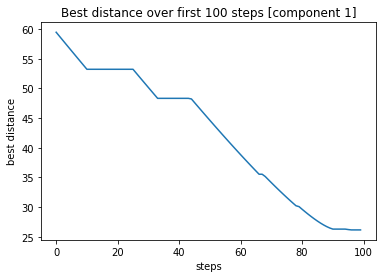

In [77]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 1]')

Text(0.5, 1.0, 'Best distance over all steps[component 1]')

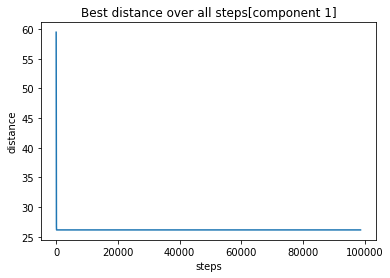

In [78]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 1]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 1')

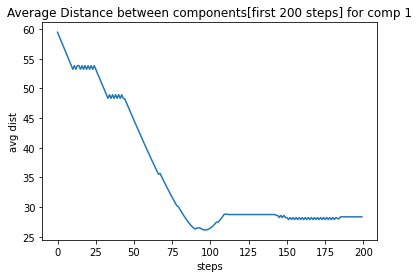

In [105]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 1')

Text(0.5, 1.0, 'Average Distance between components - comp1')

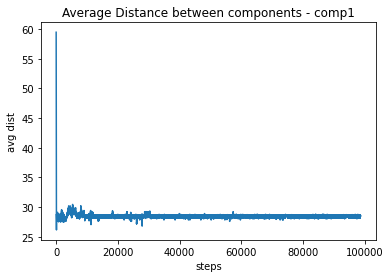

In [80]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp1')

In [81]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 1')

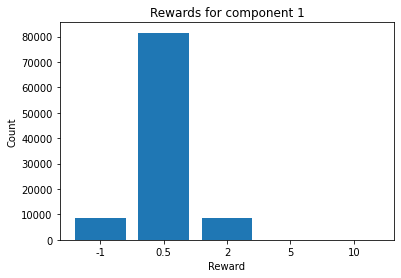

In [82]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 1')

Text(0.5, 1.0, 'Rewards for component 1')

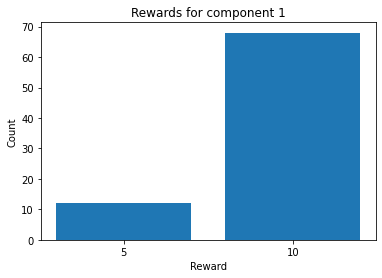

In [83]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 1')

Text(0.5, 1.0, 'Exploit vs Explore for component 1')

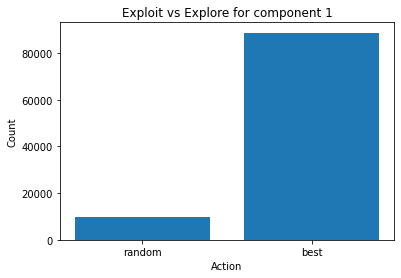

In [84]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 1')

In [106]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(2)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(2)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(2)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(2)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(2)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')


Text(0.5, 1.0, 'Best distance over first 100 steps [component 2]')

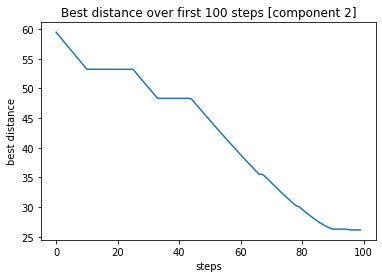

In [86]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 2]')

Text(0.5, 1.0, 'Best distance over all steps[component 2]')

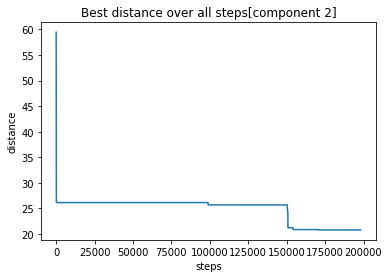

In [87]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 2]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 2')

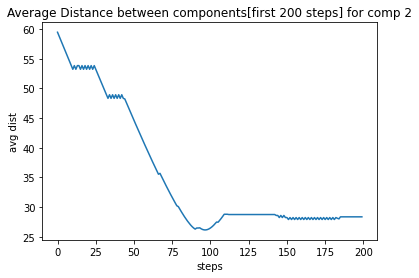

In [107]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 2')

Text(0.5, 1.0, 'Average Distance between components - comp 2')

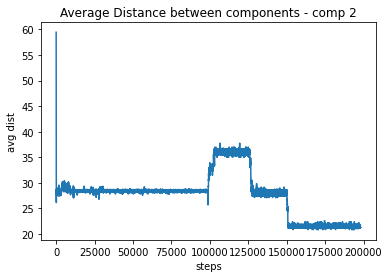

In [89]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 2')

In [90]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 2')

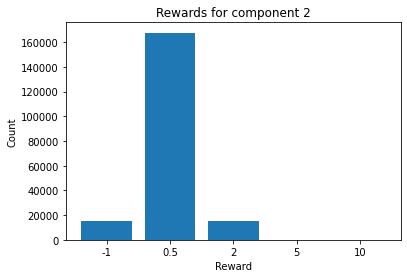

In [91]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 2')

Text(0.5, 1.0, 'Rewards for component 2')

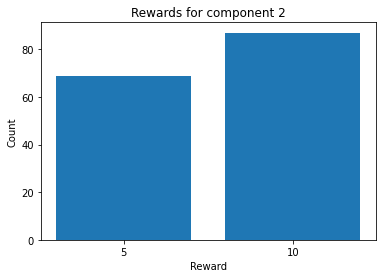

In [92]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 2')

Text(0.5, 1.0, 'Exploit vs Explore for component 2')

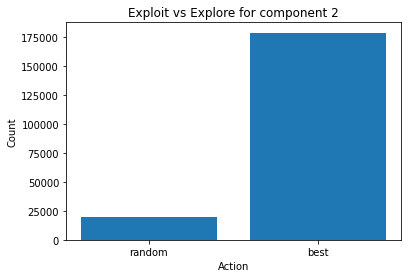

In [93]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 2')

In [108]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(7)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(7)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(7)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(7)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(7)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')


Text(0.5, 1.0, 'Best distance over first 100 steps [component 7]')

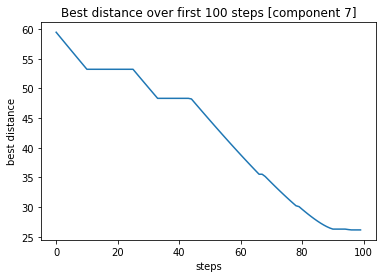

In [95]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 7]')

Text(0.5, 1.0, 'Best distance over all steps[component 7]')

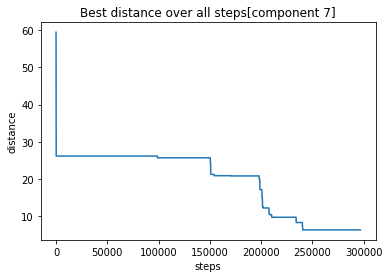

In [96]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 7]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 7')

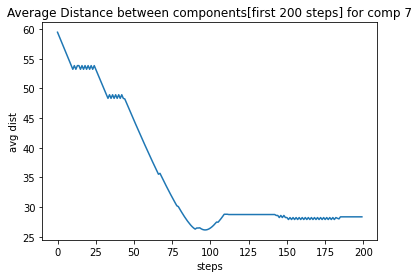

In [109]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 7')

Text(0.5, 1.0, 'Average Distance between components - comp 7')

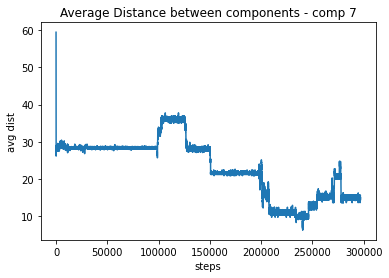

In [98]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 7')

In [99]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 7')

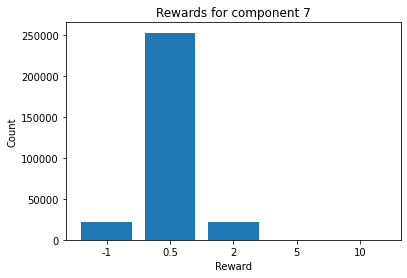

In [100]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 7')

Text(0.5, 1.0, 'Rewards for component 7')

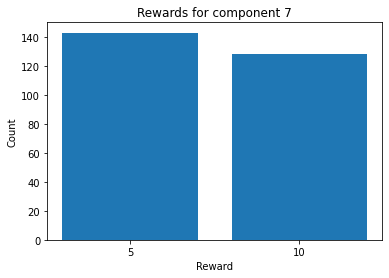

In [101]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 7')

Text(0.5, 1.0, 'Exploit vs Explore for component 7')

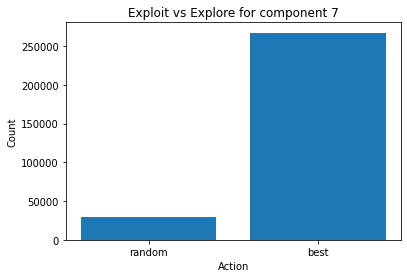

In [102]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 7')

In [ ]:
env.getComponentPosition(0)

(1, 0, 2)

In [ ]:
env.getComponentPosition(5)

(2, 0, 2)

Env space = 10x5x5 (1,2,7)

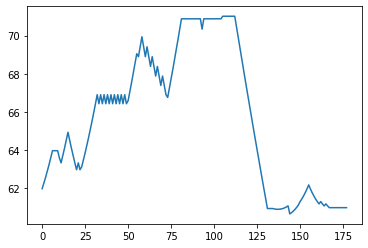

In [42]:
import matplotlib.pyplot as plt

plt.plot(env.log_avg_d)

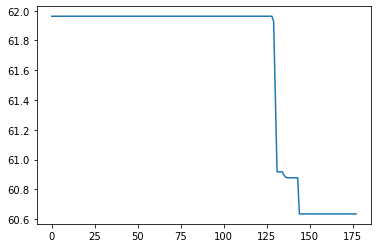

In [43]:
plt.plot(env.log_best_d)

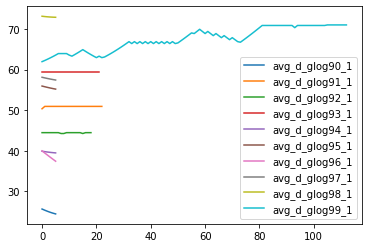

In [64]:
for x in range(90,100):
  for i in [1]:
    reward_avg_d_file_name = 'avg_d_glog'+str(x)+'_'+str(i) 
    arr = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')
    plt.plot(arr, label=reward_avg_d_file_name)
    plt.legend()
    


Try with 10x10x10 (1,2,7)

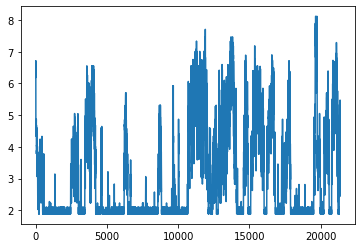

In [ ]:
plt.plot(env.log_avg_d)

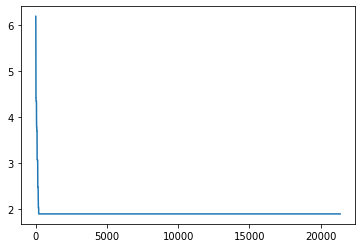

In [ ]:
plt.plot(env.log_best_d)

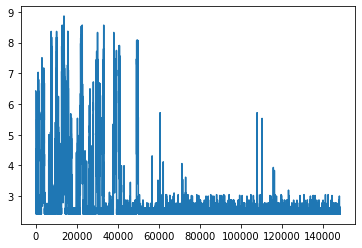

In [ ]:
plt.plot(env.log_avg_d)

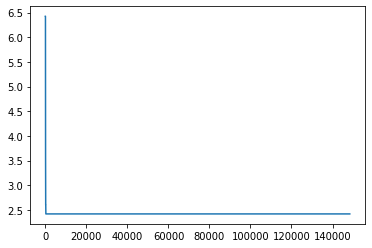

In [ ]:
plt.plot(env.log_best_d)